# Comparing Model Performance after Fine-Tuning
In this example, we will take the pre-existing SageMaker endpoints that you deployed in previous exercises and use them to generate data that can be leveraged for quality comparison. This data can be used to take a quantitative approach to judge the efficacy of fine-tuning your models.

This example will run through samples of the Samsum dataset (paper here) on the Hugging Face data hub to generate summaries of earnings calls transcripts and use the [lighteval](https://huggingface.co/docs/lighteval/index) from Hugging Face for analysis on those summaries.

In [2]:
# Install the required packages and restart the kernel
%pip install datasets pandas matplotlib numpy boto3 tqdm lighteval[math]

  Using cached antlr4_python3_runtime-4.13.2-py3-none-any.whl.metadata (304 bytes)
Using cached antlr4_python3_runtime-4.13.2-py3-none-any.whl (144 kB)
  Attempting uninstall: antlr4-python3-runtime
    Found existing installation: antlr4-python3-runtime 4.9.3
    Uninstalling antlr4-python3-runtime-4.9.3:
      Successfully uninstalled antlr4-python3-runtime-4.9.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
omegaconf 2.3.0 requires antlr4-python3-runtime==4.9.*, but you have antlr4-python3-runtime 4.13.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries
import os
import json
import time
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import load_dataset
import torch
import torchvision
import transformers

# Import LightEval metrics
from lighteval.metrics.metrics_sample import ROUGE, Doc

#### Update the base model and fine-tuned model endpoints with the names of the endpoints you previously created. 
You can find these in **SageMaker Studio > Deployments > Endpoints**

In [2]:
# Initialize the SageMaker client
sm_client = boto3.client('sagemaker-runtime')

# Configure the SageMaker endpoint names
BASE_MODEL_ENDPOINT = "huggingface-pytorch-tgi-inference-2025-04-06-21-48-45-822" # Update with Base model endpoint name
FINETUNED_MODEL_ENDPOINT = "DeepSeek-R1-Distill-Llama-8B-finetuned"  # Update with Fine-tuned model endpoint name

# Define the model to evaluate
model_to_evaluate = {
    "name": "Fine-tuned DeepSeek-R1-Distill-Llama-8B", 
    "endpoint": FINETUNED_MODEL_ENDPOINT
}

Here you will use the the Samsum dataset. The dataset is pre-split into training and test data. We will limit the number of samples to evaluate for the fine-tuned and base models.

In [3]:
# Dataset to use for evaluation - using SAMSum
dataset_name = "samsum"
split = "test"

# Limit the number of samples to evaluate (for faster execution)
num_samples = 10

# Load the test split of the SAMSum dataset
dataset = load_dataset(dataset_name, split=split)
dataset = dataset.select(range(min(num_samples, len(dataset))))
print(f"Loaded SAMSum dataset with {len(dataset)} samples")

# Display a sample from the dataset
sample = dataset[0]
print("Dialogue:\n", sample["dialogue"], "\n")
print("Summary:\n", sample["summary"])

Loaded SAMSum dataset with 10 samples
Dialogue:
 Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye 

Summary:
 Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


#### Next, we will create functions to interact with the SageMaker endpoints, define metrics we want to calculate (ROUGE), and define how to evaluate the models with the Samsum dataset. 

In [4]:
#This function allows you to interact with a deployed SageMaker endpoint to get predictions from the DeepSeek model
def invoke_sagemaker_endpoint(payload, endpoint_name):
    """
    Invoke a SageMaker endpoint with the given payload.
    
    Args:
        payload (dict): The input data to send to the endpoint
        endpoint_name (str): The name of the SageMaker endpoint
        
    Returns:
        dict: The response from the endpoint
    """
    response = sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=json.dumps(payload)
    )
    
    response_body = response['Body'].read().decode('utf-8')
    return json.loads(response_body)

In [5]:
# Initialize LightEval metrics calculators
rouge_metrics = ROUGE(
    methods=["rouge1", "rouge2", "rougeL"],
    multiple_golds=False,
    bootstrap=False,
    normalize_gold=None,
    normalize_pred=None
)

def calculate_metrics(predictions, references):
    """
    Calculate all evaluation metrics for summarization using LightEval.
    
    Args:
        predictions (list): List of generated summaries
        references (list): List of reference summaries
        
    Returns:
        dict: Dictionary containing all metric scores
    """
    metrics = {}
    
    # Create Doc objects for the Rouge and BertScore metrics
    docs = []
    for reference in references:
        docs.append(Doc(
            {"target": reference},
            choices=[reference],  # Dummy choices
            gold_index=0  # Dummy gold_index
        ))
    
    # Calculate ROUGE scores for each prediction-reference pair
    rouge_scores = {'rouge1_f': [], 'rouge2_f': [], 'rougeL_f': []}
    
    for pred, ref in zip(predictions, references):
        # For ROUGE calculation
        rouge_result = rouge_metrics.compute(golds=[ref], predictions=[pred])
        rouge_scores['rouge1_f'].append(rouge_result['rouge1'])
        rouge_scores['rouge2_f'].append(rouge_result['rouge2'])
        rouge_scores['rougeL_f'].append(rouge_result['rougeL'])
    
    # Average ROUGE scores
    for key in rouge_scores:
        metrics[key] = sum(rouge_scores[key]) / len(rouge_scores[key])
    
    return metrics

In [6]:
def generate_summaries_with_model(endpoint_name, dataset):
    """
    Generate summaries using a model deployed on SageMaker.
    
    Args:
        endpoint_name (str): SageMaker endpoint name
        dataset: Dataset containing dialogues
        
    Returns:
        list: Generated summaries
    """
    predictions = []
    
    for example in tqdm(dataset, desc="Generating summaries"):
        dialogue = example["dialogue"]
        
        # Prepare the prompt for the model
        prompt = f"""Please summarize the following conversation concisely:

Conversation:
{dialogue}

Summary:"""
        
        # Payload for SageMaker endpoint
        payload = {
            "inputs": prompt,
            "parameters": {
                "max_new_tokens": 100,
                "top_p": 0.9,
                "temperature": 0.6,
                "return_full_text": False
            }
        }
        
        # Call the model endpoint
        try:
            response = invoke_sagemaker_endpoint(payload, endpoint_name)
            
            # Extract the generated text
            if isinstance(response, list):
                prediction = response[0].get('generated_text', '').strip()
            elif isinstance(response, dict):
                prediction = response.get('generated_text', '').strip()
            else:
                prediction = str(response).strip
            
            # Clean up the generated text
            if "Summary:" in prediction:
                prediction = prediction.split("Summary:", 1)[1].strip()
                
        except Exception as e:
            print(f"Error invoking SageMaker endpoint {endpoint_name}: {e}")
            prediction = "Error generating summary."
        
        predictions.append(prediction)
    
    return predictions

In [7]:
def evaluate_model_on_samsum(model_config, dataset):
    """
    Evaluate a fine-tuned model on the SamSum dataset using both automated and human metrics.
    
    Args:
        model_config (dict): Model configuration with name and endpoint
        dataset: SamSum dataset for evaluation
        
    Returns:
        dict: Evaluation results
    """
    model_name = model_config["name"]
    endpoint_name = model_config["endpoint"]
    
    print(f"\nEvaluating model: {model_name} on endpoint: {endpoint_name}")
    
    # Get references
    references = [example["summary"] for example in dataset]
    
    # Generate summaries
    print("\nGenerating summaries...")
    predictions = generate_summaries_with_model(endpoint_name, dataset)
    
    # Calculate automated metrics using LightEval
    print("\nCalculating evaluation metrics with LightEval...")
    metrics = calculate_metrics(predictions, references)
    
    # Format results
    results = {
        "model_name": model_name,
        "endpoint_name": endpoint_name,
        "num_samples": len(dataset),
        "metrics": metrics,
        "predictions": predictions[:5],  # First 5 predictions
        "references": references[:5]     # First 5 references
    }
    
    # Print key results
    print(f"\nResults for {model_name}:")
    print(f"ROUGE-1 F1: {metrics['rouge1_f']:.4f}")
    print(f"ROUGE-2 F1: {metrics['rouge2_f']:.4f}")
    print(f"ROUGE-L F1: {metrics['rougeL_f']:.4f}")
    
    return results

#### In this section, we evaluate the performance of both our base model (DeepSeek-R1-Distill-Llama-8B) and our fine-tuned model on the SAMSum dataset using ROUGE metrics, which are standard for evaluating text summarization quality.

The evaluation process:

We first evaluate the base model against the SAMSum test set to establish a baseline performance. Then, we evaluate our fine-tuned model on the same dataset to measure improvements. Both evaluations calculate ROUGE-1, ROUGE-2, and ROUGE-L scores, which respectively measure:

ROUGE-1: Unigram overlap between generated and reference summaries
ROUGE-2: Bigram overlap (captures more fluency and coherence)
ROUGE-L: Longest common subsequence (measures sentence structure similarity)

The results are saved to JSON files for later analysis and comparison. These metrics will help us quantify how much our fine-tuning process has improved the model's summarization capabilities compared to the original base model.

In [8]:
# Evaluate the base and fine-tuned models using LightEval metrics
start_time = time.time()

# Evaluate both models for comparison
base_model_config = {
    "name": "Base DeepSeek-R1-Distill-Llama-8B",
    "endpoint": BASE_MODEL_ENDPOINT
}

# Evaluate base model
base_model_results = evaluate_model_on_samsum(base_model_config, dataset)
base_model_results["evaluation_time"] = time.time() - start_time

# Start timing fine-tuned model
start_time = time.time()

# Evaluate fine-tuned model
finetuned_model_results = evaluate_model_on_samsum(model_to_evaluate, dataset)
finetuned_model_results["evaluation_time"] = time.time() - start_time

# Save results
base_file_name = base_model_config["name"].replace(' ', '_').lower()
finetuned_file_name = model_to_evaluate["name"].replace(' ', '_').lower()

with open(f"{base_file_name}_results.json", "w") as f:
    json.dump(base_model_results, f)
    
with open(f"{finetuned_file_name}_results.json", "w") as f:
    json.dump(finetuned_model_results, f)


Evaluating model: Base DeepSeek-R1-Distill-Llama-8B on endpoint: huggingface-pytorch-tgi-inference-2025-04-06-21-48-45-822

Generating summaries...


Generating summaries:   0%|          | 0/10 [00:00<?, ?it/s]


Calculating evaluation metrics with LightEval...

Results for Base DeepSeek-R1-Distill-Llama-8B:
ROUGE-1 F1: 0.2471
ROUGE-2 F1: 0.0646
ROUGE-L F1: 0.1683

Evaluating model: Fine-tuned DeepSeek-R1-Distill-Llama-8B on endpoint: DeepSeek-R1-Distill-Llama-8B-finetuned

Generating summaries...


Generating summaries:   0%|          | 0/10 [00:00<?, ?it/s]


Calculating evaluation metrics with LightEval...

Results for Fine-tuned DeepSeek-R1-Distill-Llama-8B:
ROUGE-1 F1: 0.2700
ROUGE-2 F1: 0.0998
ROUGE-L F1: 0.2030


Create a tablular view to compare the base model and fine-tuned model performance metrics

In [9]:
# Create a comparison DataFrame
comparison_data = []

# Add base model metrics
comparison_data.append({
    "Model": base_model_config["name"],
    "ROUGE-1 F1": base_model_results["metrics"]["rouge1_f"],
    "ROUGE-2 F1": base_model_results["metrics"]["rouge2_f"],
    "ROUGE-L F1": base_model_results["metrics"]["rougeL_f"],
    "Evaluation Time (s)": base_model_results["evaluation_time"]
})

# Add fine-tuned model metrics
comparison_data.append({
    "Model": model_to_evaluate["name"],
    "ROUGE-1 F1": finetuned_model_results["metrics"]["rouge1_f"],
    "ROUGE-2 F1": finetuned_model_results["metrics"]["rouge2_f"],
    "ROUGE-L F1": finetuned_model_results["metrics"]["rougeL_f"],
    "Evaluation Time (s)": finetuned_model_results["evaluation_time"]
})

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
comparison_df

Model Comparison:


,Model,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1,Evaluation Time (s)
0,Base DeepSeek-R1-Distill-Llama-8B,0.247079,0.064579,0.168272,35.473946
1,Fine-tuned DeepSeek-R1-Distill-Llama-8B,0.270049,0.099848,0.203041,35.705987


Show a bar chart

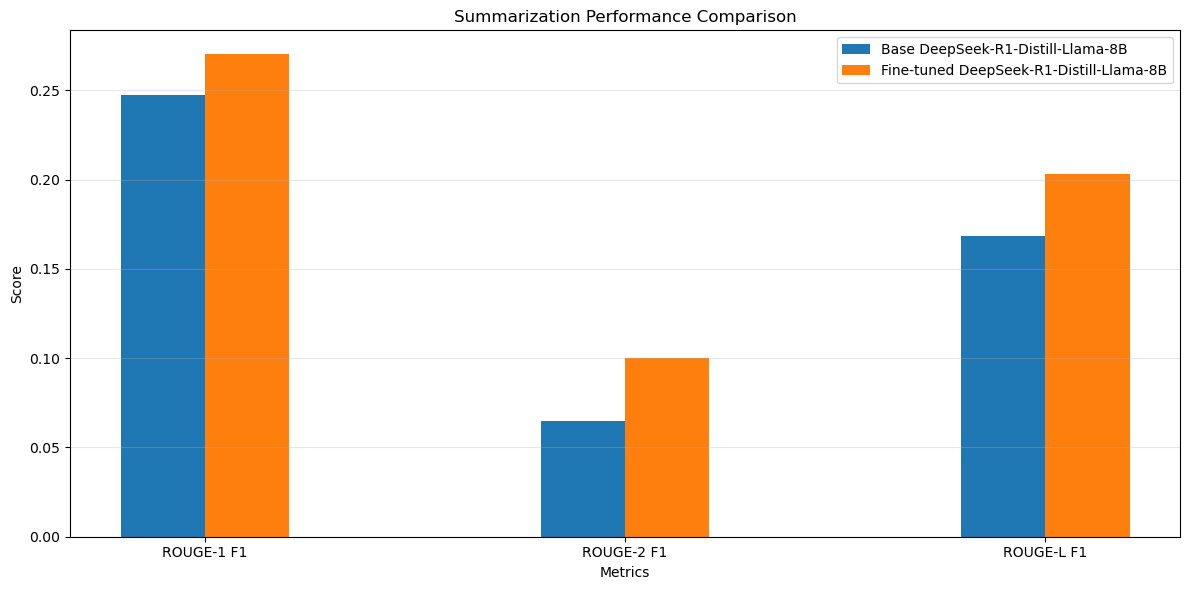

In [10]:
# Plot ROUGE and BERTScore metrics for both models
metrics_to_plot = ["ROUGE-1 F1", "ROUGE-2 F1", "ROUGE-L F1"]
models = comparison_df["Model"].tolist()

# Create a grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(metrics_to_plot))

for i, model in enumerate(models):
    values = [comparison_df.loc[i, metric] for metric in metrics_to_plot]
    plt.bar(index + i*bar_width, values, bar_width, label=model)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Summarization Performance Comparison')
plt.xticks(index + bar_width/2, metrics_to_plot)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [11]:
# Calculate improvement from base to fine-tuned model
improvement_data = {}

for metric in ["ROUGE-1 F1", "ROUGE-2 F1", "ROUGE-L F1"]:
    base_value = comparison_df.loc[0, metric]
    finetuned_value = comparison_df.loc[1, metric]
    
    if not pd.isna(base_value) and not pd.isna(finetuned_value):
        abs_improvement = finetuned_value - base_value
        pct_improvement = (abs_improvement / base_value) * 100 if base_value > 0 else float('inf')
        
        improvement_data[metric] = {
            "Base Model": base_value,
            "Fine-tuned Model": finetuned_value,
            "Absolute Improvement": abs_improvement,
            "% Improvement": pct_improvement
        }

# Create DataFrame for improvement metrics
improvement_df = pd.DataFrame({
    "Metric": list(improvement_data.keys()),
    "Base Score": [improvement_data[m]["Base Model"] for m in improvement_data],
    "Fine-tuned Score": [improvement_data[m]["Fine-tuned Model"] for m in improvement_data],
    "Absolute Improvement": [improvement_data[m]["Absolute Improvement"] for m in improvement_data],
    "% Improvement": [f"{improvement_data[m]['% Improvement']:.2f}%" for m in improvement_data]
})

print("Improvement Analysis:")
improvement_df

Improvement Analysis:


,Metric,Base Score,Fine-tuned Score,Absolute Improvement,% Improvement
0,ROUGE-1 F1,0.247079,0.270049,0.022970,9.30%
1,ROUGE-2 F1,0.064579,0.099848,0.035269,54.61%
2,ROUGE-L F1,0.168272,0.203041,0.034769,20.66%


In [12]:
# Display example predictions from both models
num_examples = min(3, len(dataset))

for i in range(num_examples):
    print(f"\nExample {i+1}:")
    print(f"Dialogue (truncated): {dataset[i]['dialogue'][:150]}...")
    print(f"\nReference Summary: {dataset[i]['summary']}")
    
    # Show predictions from both models
    print(f"\nBase Model Summary: {base_model_results['predictions'][i]}")
    print(f"\nFine-tuned Model Summary: {finetuned_model_results['predictions'][i]}")
    
    # Calculate ROUGE scores for this example using LightEval
    base_rouge = rouge_metrics.compute(golds=[dataset[i]['summary']], predictions=[base_model_results['predictions'][i]])
    finetuned_rouge = rouge_metrics.compute(golds=[dataset[i]['summary']], predictions=[finetuned_model_results['predictions'][i]])
    
    print("\nROUGE Scores (LightEval):")
    print(f"Base Model - ROUGE-1: {base_rouge['rouge1']:.4f}, ROUGE-2: {base_rouge['rouge2']:.4f}, ROUGE-L: {base_rouge['rougeL']:.4f}")
    print(f"Fine-tuned - ROUGE-1: {finetuned_rouge['rouge1']:.4f}, ROUGE-2: {finetuned_rouge['rouge2']:.4f}, ROUGE-L: {finetuned_rouge['rougeL']:.4f}")
    
    print("\n" + "="*80)


Example 1:
Dialogue (truncated): Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her ...

Reference Summary: Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Base Model Summary: [Your concise summary here]
---

Alright, so I need to summarize this conversation between Hannah and Amanda. Let me read through it carefully to understand what's going on.

Hannah starts by asking Amanda if she has Betty's number. Amanda says she'll check. Then Hannah sends a file_gif, which I think might be an emoji or some kind of media file. Amanda responds that she can't find the number, so she suggests asking Larry. She mentions that Larry called Betty last time they

Fine-tuned Model Summary: Hannah asks Amanda for Betty's number, Amanda says she can't find it and suggests asking Larry, who called Betty last time they were at the park together. Amanda encourages Hannah t